# Cyber Threat Intelligence project

Na githubu preprocessing datasetova: https://github.com/lilhast1/viproject

In [ ]:
# deletion of unneeded content
import shutil
import os
# %cd ../
# gets loaded unnecessarilly so I delete it

folder_path = 'sample_data'

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print(f"Deleted folder: {folder_path}")
else:
    print(f"Folder not found: {folder_path}")


Deleted folder: sample_data


In [ ]:
# Clone the entire repo
!git clone https://github.com/lilhast1/viproject.git #as preprocessing and .csv datasets are here

# Change directory to the repo
%cd viproject


Cloning into 'viproject'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 94 (delta 5), reused 18 (delta 4), pack-reused 71 (from 1)
Receiving objects: 100% (94/94), 71.23 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/content/viproject


## Packages

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import unicodedata

### Helper functions for processing

In [ ]:
def df_info(df):
    print(f"Dataset shape: {df.shape}")
    print(f"Label distribution:\n{df['label'].value_counts()}")
    print(f"Label distribution (percentage):\n{df['label'].value_counts(normalize=True) * 100}")

In [ ]:
def get_text_stats(text):
    """Calculate various text statistics"""
    # Count words (simple split on whitespace)
    words = str(text).split()
    word_count = len(words)

    # Count characters
    char_count = len(str(text))

    # Count sentences (rough approximation)
    sentence_count = len(re.split(r'[.!?]+', str(text))) - 1
    sentence_count = max(1, sentence_count)  # Ensure at least 1 sentence

    # Average word length
    avg_word_length = np.mean([len(word) for word in words]) if words else 0

    # Average sentence length in words
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return {
        'word_count': word_count,
        'char_count': char_count,
        'sentence_count': sentence_count,
        'avg_word_length': avg_word_length,
        'avg_sentence_length': avg_sentence_length
    }

In [ ]:
def text_len_dist(stats):
    plt.figure(figsize=(12, 6))
    sns.histplot(stats['word_count'], bins=30, kde=True)
    plt.title('Distribution of Text Length (Word Count)')
    plt.xlabel('Number of Words')
    plt.ylabel('Frequency')
    plt.axvline(stats['word_count'].median(), color='red', linestyle='--', label=f'Median: {stats["word_count"].median():.1f}')
    plt.axvline(stats['word_count'].mean(), color='green', linestyle='--', label=f'Mean: {stats["word_count"].mean():.1f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:

# Step 1.1: Normalize URLs
def normalize_urls(text):
    """
    Normalize URLs to a standard format
    Options:
    1. Replace all URLs with a token like [URL]
    2. Keep domain only
    3. Remove completely
    """
    # Option 1: Replace URLs with [URL] token
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub('[URL]', text)

    # Option 2: Keep domain name only (uncomment if preferred)
    # def replace_with_domain(match):
    #     url = match.group(0)
    #     domain_match = re.search(r'(?:https?://)?(?:www\.)?([^/]+)', url)
    #     if domain_match:
    #         return f"[{domain_match.group(1)}]"
    #     return "[URL]"
    # return url_pattern.sub(replace_with_domain, text)

    # Option 3: Remove URLs completely (uncomment if preferred)
    # return url_pattern.sub('', text)

In [ ]:

# Step 1.2: Standardize different quote types
def standardize_quotes(text):
    """
    Standardize all quotation marks to straight double quotes (")
    """
    # List of quote characters to normalize
    quotes = ["'", "'", '`', '¬¥', '"', '"', '‚Äû', '‚Äü', '¬´', '¬ª', '‚Äπ', '‚Ä∫', '‚Äú', '‚Äù']

    # Replace all opening/closing quotes with standard double quotes
    for quote in quotes:
        text = text.replace(quote, '"')

    # Replace single quotes with standard single quote
    text = text.replace(''', "'")
    text = text.replace(''', "'")

    return text

In [ ]:
def normalize_punctuation(text):
    """
    Normalize punctuation marks and spacing around them
    """
    # Normalize unicode punctuation to ASCII equivalents where possible
    text = unicodedata.normalize('NFKD', text)

    # Standardize dashes
    text = re.sub(r'‚Äî|‚Äì|‚Äê|‚Äí|‚Äï|‚ÅÉ', '-', text)

    return text

In [ ]:

def lowercase_text(text):
    return text.lower()

def remove_extra_whitespace(text):
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    return text

In [ ]:
def preprocess_text(text):
    # Apply each preprocessing step
    text = normalize_urls(text)
    text = standardize_quotes(text)
    text = normalize_punctuation(text)
    text = lowercase_text(text)
    text = remove_extra_whitespace(text)

    return text

## Datasets

### LADDER dataset - CTI

In [ ]:
ladder_smthn_dev = pd.read_csv('LADDER_dataset/dev.csv', sep='\t')
ladder_train = pd.read_csv('LADDER_dataset/train.csv', sep='\t')
ladder_test = pd.read_csv('LADDER_dataset/test.csv', sep='\t')

In [ ]:
merged_ladder = pd.concat([ladder_train, ladder_test, ladder_smthn_dev], ignore_index=True)

In [ ]:
df_info(merged_ladder)

Dataset shape: (3444, 2)
Label distribution:
label
1    1722
0    1722
Name: count, dtype: int64
Label distribution (percentage):
label
1    50.0
0    50.0
Name: proportion, dtype: float64


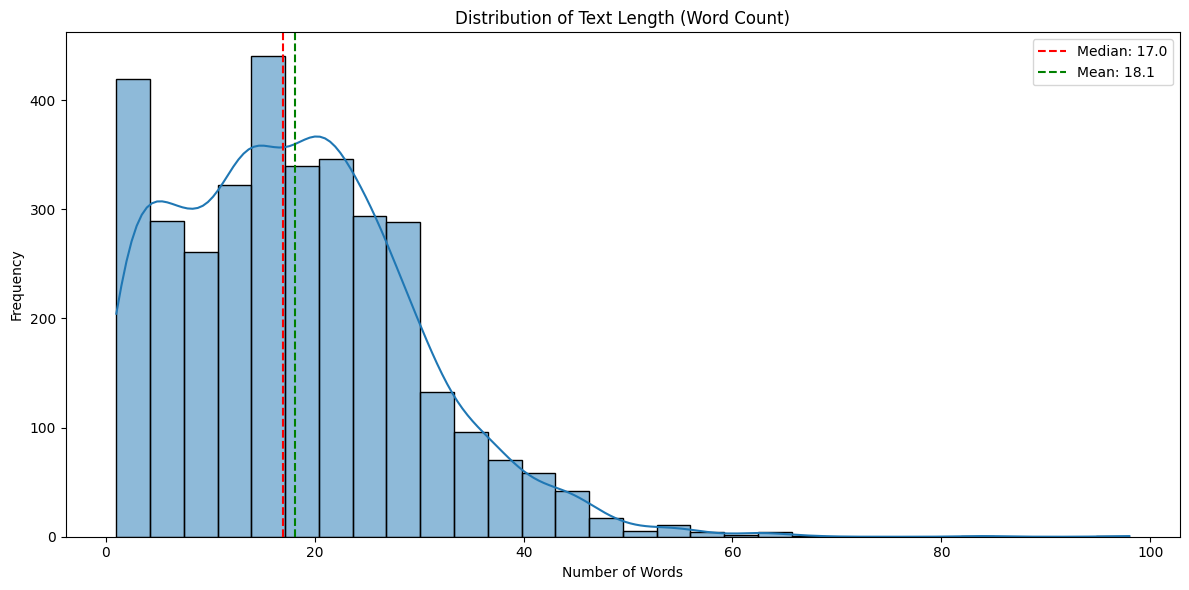

In [ ]:
ladder_stats = pd.DataFrame(merged_ladder['text'].apply(get_text_stats).tolist())
text_len_dist(ladder_stats)

In [ ]:
merged_ladder['text'] = merged_ladder['text'].apply(preprocess_text)

merged_ladder.to_csv('LADDER_preprocessing/ladder_preprocessed.csv', index=False)

### Social Media dataset

In [ ]:
soc_media = pd.read_csv('Social_media_dataset_preprocessing/social_media.csv')
soc_media['label'] = 0
soc_media = soc_media.rename(columns={'message': 'text'})


In [ ]:
df_info(soc_media)

Dataset shape: (63018, 2)
Label distribution:
label
0    63018
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


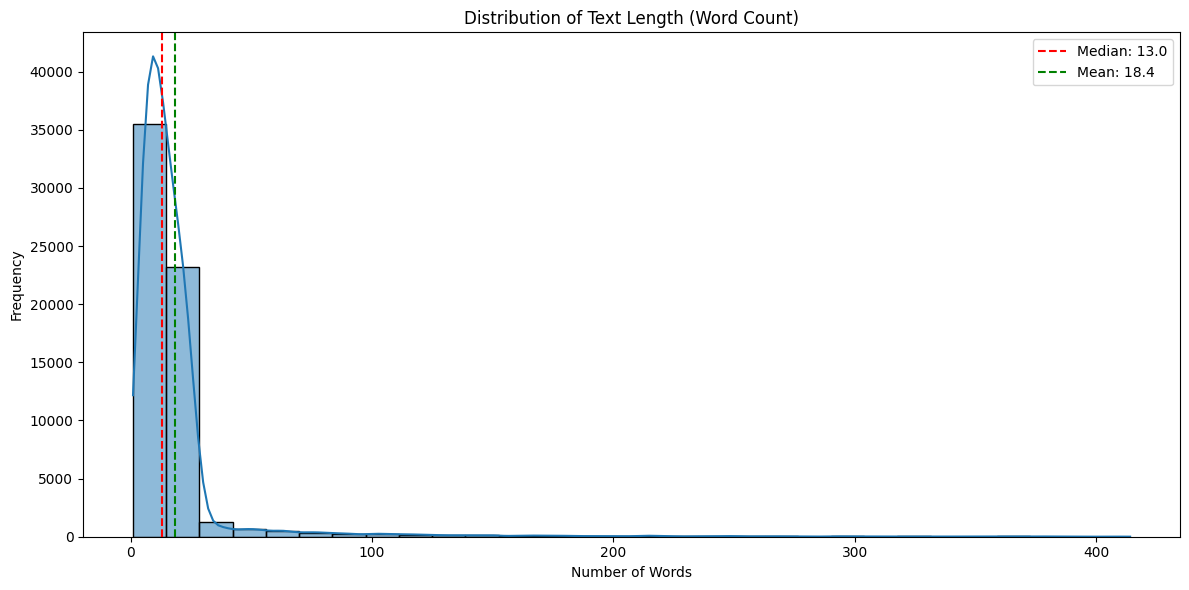

In [ ]:
soc_media_stats = pd.DataFrame(soc_media['text'].apply(get_text_stats).tolist())
text_len_dist(soc_media_stats)

Dataset shape: (1576, 2)
Label distribution:
label
0    1576
Name: count, dtype: int64
Label distribution (percentage):
label
0    100.0
Name: proportion, dtype: float64


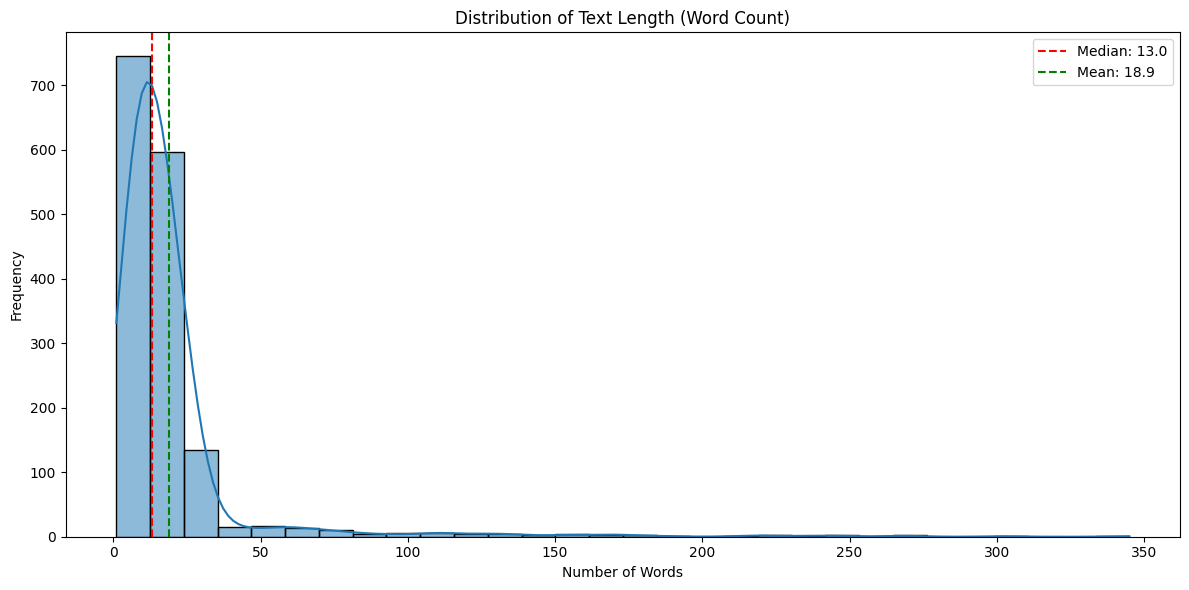

In [ ]:
soc_media_skraceno = soc_media.iloc[::40]
df_info(soc_media_skraceno)
stats = pd.DataFrame(soc_media_skraceno['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [ ]:
df = pd.concat([merged_ladder, soc_media_skraceno], ignore_index=True)

Dataset shape: (5020, 2)
Label distribution:
label
0    3298
1    1722
Name: count, dtype: int64
Label distribution (percentage):
label
0    65.697211
1    34.302789
Name: proportion, dtype: float64


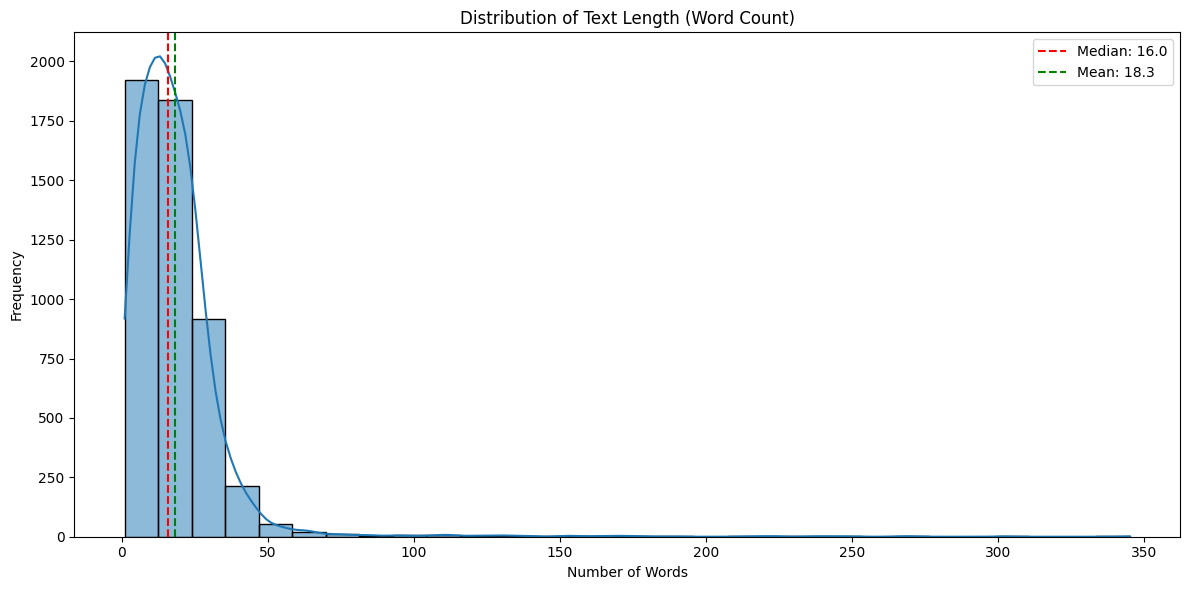

In [ ]:
df_info(df)
stats = pd.DataFrame(df['text'].apply(get_text_stats).tolist())
text_len_dist(stats)

In [ ]:
df.to_csv('merged_Social_Media_LADDER/ladder_social_media.csv', index=False)

df.iloc[241]

text     "hi", "ask" - enable and disable mobile internet;
label                                                    1
Name: 241, dtype: object

## Preprocesing

In [ ]:
df.describe()

label
count  5020.000000
mean      0.343028
std       0.474768
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

In [ ]:
df.tail(10)

text  label
5010  Remember me??? Full video is on my yt channel ...      0
5011  Im in my DIY era We are having a go at renovat...      0
5012  My valentine for 13 years now CRAZY how time f...      0
5013  What if optimizing for the present means also ...      0
5014  Transported to Japan for the night, at The arc...      0
5015                                Florida we love you      0
5016  We are always continuously evolving and its es...      0
5017  A magical morning at Bow Lake. beautiful skies...      0
5018  This is your sign to slow down and enjoy the l...      0
5019  BMW i8 SIGN up for IG Video GUIDES and learn h...      0

In [ ]:
import torch
from transformers import BertTokenizer, BertModel, AutoTokenizer

# For more details - https://huggingface.co/bert-base-uncased
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
MAX_LENGTH = 256

encoded_inputs = tokenizer(
    df['text'].tolist(),          # List of sentences
    padding='max_length',         # Pad to MAX_LENGTH
    truncation=True,              # Truncate to MAX_LENGTH
    max_length=MAX_LENGTH,
    return_attention_mask=True,   # Return attention mask
    return_tensors=None           # Return Python lists for now (easier to add to df)
                                  # Use 'pt' or 'tf' if directly feeding to model
)

In [ ]:
df['input_ids'] = encoded_inputs['input_ids']
df['attention_mask'] = encoded_inputs['attention_mask']
df['token_type_ids'] = encoded_inputs['token_type_ids']


In [ ]:
df.head()

text  label  \
0  using the device accelerometer sensor it imple...      1   
1  when the malware is first started on the devic...      1   
2  then it will ask for the accessibility service...      1   
3  after the user grants the requested privilege,...      1   
4  it also disables play protect (google‚Äôs preins...      1   

                                           input_ids  \
0  [101, 2478, 1996, 5080, 16222, 12260, 21716, 1...   
1  [101, 2043, 1996, 15451, 8059, 2003, 2034, 231...   
2  [101, 2059, 2009, 2097, 3198, 2005, 1996, 2366...   
3  [101, 2044, 1996, 5310, 8624, 1996, 7303, 1429...   
4  [101, 2009, 2036, 4487, 19150, 2015, 2377, 404...   

                                      attention_mask  \
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...   

                                      token_type_ids  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...

In [ ]:
print(df)

                                                   text  label  \
0     using the device accelerometer sensor it imple...      1   
1     when the malware is first started on the devic...      1   
2     then it will ask for the accessibility service...      1   
3     after the user grants the requested privilege,...      1   
4     it also disables play protect (google‚Äôs preins...      1   
...                                                 ...    ...   
5015                                Florida we love you      0   
5016  We are always continuously evolving and its es...      0   
5017  A magical morning at Bow Lake. beautiful skies...      0   
5018  This is your sign to slow down and enjoy the l...      0   
5019  BMW i8 SIGN up for IG Video GUIDES and learn h...      0   

                                              input_ids  \
0     [101, 2478, 1996, 5080, 16222, 12260, 21716, 1...   
1     [101, 2043, 1996, 15451, 8059, 2003, 2034, 231...   
2     [101, 2059, 2009, 2097

In [ ]:
input_ids_tensor = torch.tensor(df['input_ids'].tolist())
attention_mask_tensor = torch.tensor(df['attention_mask'].tolist())
token_type_ids_tensor = torch.tensor(df['token_type_ids'].tolist())
labels_tensor = torch.tensor(df['label'].tolist())

In [ ]:
print("\nPyTorch Tensors:")
print(f"Input IDs Tensor shape: {input_ids_tensor.shape}")
print(f"Attention Mask Tensor shape: {attention_mask_tensor.shape}")
print(f"Labels Tensor shape: {labels_tensor.shape}")


PyTorch Tensors:
Input IDs Tensor shape: torch.Size([5020, 256])
Attention Mask Tensor shape: torch.Size([5020, 256])
Labels Tensor shape: torch.Size([5020])


## BERT

Using device: cuda
Training samples: 4016
Validation samples: 1004


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



======== Epoch 1 / 3 ========
Training...
  Batch    20  of     63. Loss: 0.3972
  Batch    40  of     63. Loss: 0.3483
  Batch    60  of     63. Loss: 0.4336
  Batch    63  of     63. Loss: 0.2609
  Average training loss: 0.4094
  Training Accuracy: 0.8140, Training F1: 0.8137

Running Validation...
  Validation Loss: 0.2560
  Validation Accuracy: 0.9034, Validation F1: 0.9045
Best model saved with accuracy: 0.9034

======== Epoch 2 / 3 ========
Training...
  Batch    20  of     63. Loss: 0.3486
  Batch    40  of     63. Loss: 0.2556
  Batch    60  of     63. Loss: 0.2185
  Batch    63  of     63. Loss: 0.3996
  Average training loss: 0.2776
  Training Accuracy: 0.8852, Training F1: 0.8862

Running Validation...
  Validation Loss: 0.2303
  Validation Accuracy: 0.9054, Validation F1: 0.9064
Best model saved with accuracy: 0.9054

======== Epoch 3 / 3 ========
Training...
  Batch    20  of     63. Loss: 0.2644
  Batch    40  of     63. Loss: 0.2638
  Batch    60  of     63. Loss: 0.353

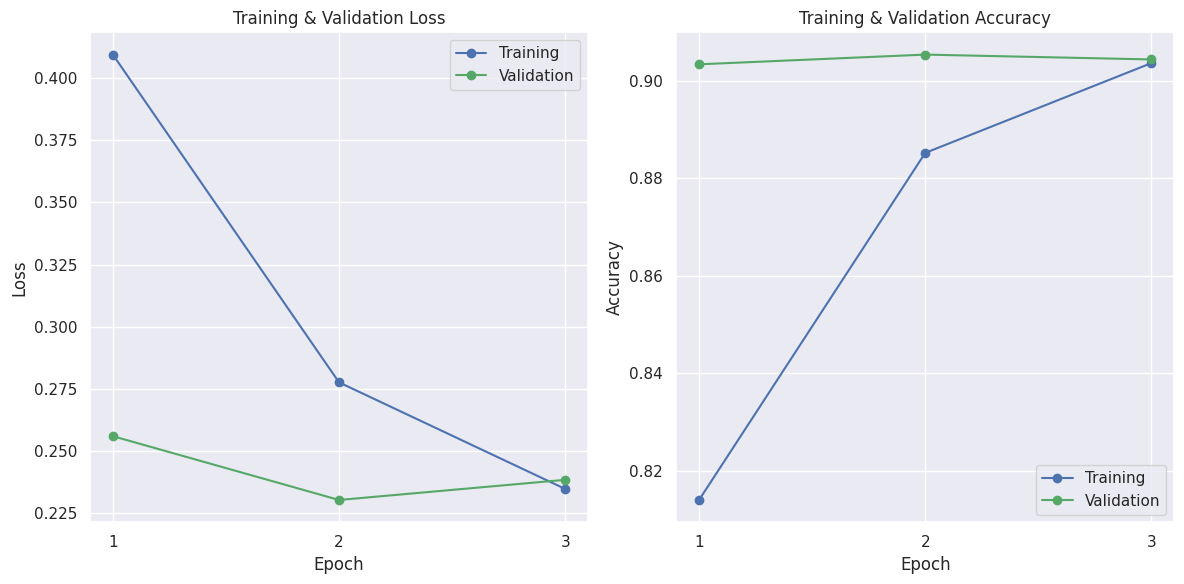


Generating confusion matrix for the validation set...


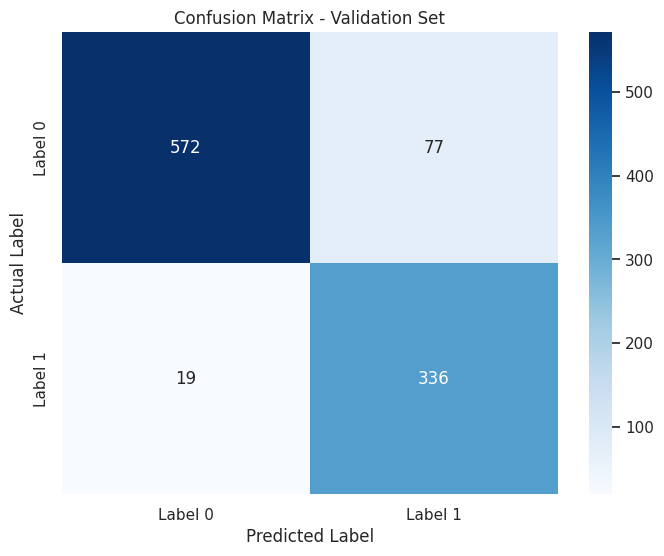

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

# --- NEW: Imports for plotting ---
import matplotlib.pyplot as plt
import seaborn as sns


# --- 0. Configuration ---
MODEL_NAME = 'bert-base-uncased' # Should be the same as used for tokenization
MAX_LENGTH = 128                 # Should be the same as used for tokenization
BATCH_SIZE = 64                  # Adjust based on your GPU memory
EPOCHS = 3                       # Number of training epochs
LEARNING_RATE = 2e-5             # Common learning rate for BERT fine-tuning
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")


# --- 2. Tokenize (if not already done, or to ensure consistency) ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

encoded_inputs = tokenizer(
    df['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_attention_mask=True,
    return_tensors='pt' # Return PyTorch tensors directly
)

input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']
labels = torch.tensor(df['label'].values)

# --- 3. Create PyTorch Datasets and DataLoaders ---
dataset = TensorDataset(input_ids, attention_mask, labels)

# Split into training and validation (e.g., 80% train, 20% val)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 4. Load Pre-trained BERT Model for Sequence Classification ---
# num_labels=2 because we have binary classification (0 or 1)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2, # Number of output labels (0 and 1)
    output_attentions=False, # Optional: set to True if you want attentions
    output_hidden_states=False, # Optional: set to True if you want hidden states,
    hidden_dropout_prob=0.2, # Default is 0.1. Increase it.
    attention_probs_dropout_prob=0.2
)
model.to(DEVICE)

# --- 5. Define Optimizer and Learning Rate Scheduler ---
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8, weight_decay=1e-2)

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * EPOCHS

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0, # Default value in run_glue.py
    num_training_steps=total_steps
)

# --- 6. Training Loop ---
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train() # Set model to training mode
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch_num, batch in enumerate(dataloader):
        # Unpack batch and move to device
        b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

        model.zero_grad() # Clear previously calculated gradients

        # Forward pass
        outputs = model(
            input_ids=b_input_ids,
            attention_mask=b_attention_mask,
            labels=b_labels # Model calculates loss internally if labels are provided
        )

        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()
        scheduler.step() # Update learning rate

        # Store predictions and labels for metrics
        preds = torch.argmax(logits, dim=1).flatten()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(b_labels.cpu().numpy())

        if (batch_num + 1) % 20 == 0 or batch_num == len(dataloader) -1 :
            print(f'  Batch {batch_num+1:>5,}  of  {len(dataloader):>5,}. Loss: {loss.item():.4f}')


    avg_train_loss = total_loss / len(dataloader)
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_train_loss, train_accuracy, train_f1

def evaluate(model, dataloader, device):
    model.eval() # Set model to evaluation mode
    total_eval_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad(): # Deactivate autograd for evaluation
        for batch in dataloader:
            b_input_ids, b_attention_mask, b_labels = [b.to(device) for b in batch]

            outputs = model(
                input_ids=b_input_ids,
                attention_mask=b_attention_mask,
                labels=b_labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = total_eval_loss / len(dataloader)
    val_accuracy = accuracy_score(all_labels, all_preds)
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    # MODIFICATION: Return labels and preds for confusion matrix
    return avg_val_loss, val_accuracy, val_f1, all_labels, all_preds

# --- 8. Start Training and Evaluation ---
best_val_accuracy = 0
training_stats = []

for epoch_i in range(EPOCHS):
    print(f"\n======== Epoch {epoch_i + 1} / {EPOCHS} ========")
    print("Training...")
    avg_train_loss, train_acc, train_f1 = train_epoch(model, train_dataloader, optimizer, scheduler, DEVICE)
    print(f"  Average training loss: {avg_train_loss:.4f}")
    print(f"  Training Accuracy: {train_acc:.4f}, Training F1: {train_f1:.4f}")

    print("\nRunning Validation...")
    avg_val_loss, val_acc, val_f1, _, _ = evaluate(model, val_dataloader, DEVICE)
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_acc:.4f}, Validation F1: {val_f1:.4f}")

    training_stats.append({
        'epoch': epoch_i + 1,
        'Training Loss': avg_train_loss,
        'Valid. Loss': avg_val_loss,
        'Training Acc.': train_acc,
        'Valid. Acc.': val_acc,
        'Training F1': train_f1,
        'Valid. F1': val_f1
    })

    if val_acc > best_val_accuracy:
        best_val_accuracy = val_acc
        torch.save(model.state_dict(), f'{MODEL_NAME}-best-model.pt')
        print(f"Best model saved with accuracy: {best_val_accuracy:.4f}")


print("\nTraining complete!")
print("Training Statistics:")
for stat in training_stats:
    print(stat)

# --- 9. NEW: Plot Loss and Accuracy Curves ---
df_stats = pd.DataFrame(data=training_stats)

# Use plot styling from seaborn.
sns.set(style='darkgrid')
plt.rcParams["figure.figsize"] = (12, 6)

# Create a single figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plot training & validation loss values
ax1.plot(df_stats['epoch'], df_stats['Training Loss'], 'b-o', label="Training")
ax1.plot(df_stats['epoch'], df_stats['Valid. Loss'], 'g-o', label="Validation")
ax1.set_title("Training & Validation Loss")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.legend()
ax1.set_xticks(np.arange(1, EPOCHS + 1, 1))

# Plot training & validation accuracy values
ax2.plot(df_stats['epoch'], df_stats['Training Acc.'], 'b-o', label="Training")
ax2.plot(df_stats['epoch'], df_stats['Valid. Acc.'], 'g-o', label="Validation")
ax2.set_title("Training & Validation Accuracy")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Accuracy")
ax2.legend()
ax2.set_xticks(np.arange(1, EPOCHS + 1, 1))

# Display the plot
plt.tight_layout()
plt.show()


# --- 10. NEW: Generate and Plot Confusion Matrix ---
print("\nGenerating confusion matrix for the validation set...")

# Get predictions on the validation set from the fully trained model
_, _, _, val_labels, val_preds = evaluate(model, val_dataloader, DEVICE)

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_preds)

# Define class names (optional, but makes the plot clearer)
class_names = ['Label 0', 'Label 1'] # e.g., ['Negative', 'Positive']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ---  Save the fine-tuned model and tokenizer ---
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained("/content/drive/My Drive/my_bert_classifier")
tokenizer.save_pretrained("/content/drive/My Drive/my_bert_classifier")
print("Model and tokenizer saved to ./my_bert_classifier")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save_pretrained("/content/drive/My Drive/my_bert_classifier")
tokenizer.save_pretrained("/content/drive/My Drive/my_bert_classifier")
print("Model and tokenizer saved to ./my_bert_classifier")

Mounted at /content/drive
Model and tokenizer saved to ./my_bert_classifier


## LSTM

 za LSTM ide procesiranje-odabirModela-treniranje, prikaz i plotanje rezultata

Augmented dataset koji je koristen za iteraciju2 dostupan na driveu: https://drive.google.com/file/d/1FhGrzHg0HPLz3qneoGRv4a_oZCPNcT_C/view?usp=drive_link

Komparativno uradjeno i bez aug modele da se uporedi

Na kraju ima celija za import LSTM modela koji su dobijeni i o kojim je diskutovalo se u dokumentaciji *(import je sa drivea)*

### bertovo processing ponudjeno iznad - losiji score mnogo, overfita, zanemariti ovaj model (ovdje je samo pokazno)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Class Weights: {np.int64(0): np.float64(0.7610673135233474), np.int64(1): np.float64(1.4576074332171893)}
Epoch 1/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 9ms/step - accuracy: 0.7704 - loss: 0.4694 - val_accuracy: 0.8501 - val_loss: 0.3250
Epoch 2/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - accuracy: 0.8556 - loss: 0.3209 - val_accuracy: 0.8674 - val_loss: 0.3065
Epoch 3/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - accuracy: 0.8776 - loss: 0.2803 - val_accuracy: 0.8687 - val_loss: 0.3028
Epoch 4/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - accuracy: 0.8775 - loss: 0.2700 - val_accuracy: 0.8793 - val_loss: 0.2842
Epoch 5/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 6ms/step - accuracy: 0.8970 - loss: 0.2405 - val_accuracy: 0.8435 - val_loss: 0.3482
Epoch 6/10
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î

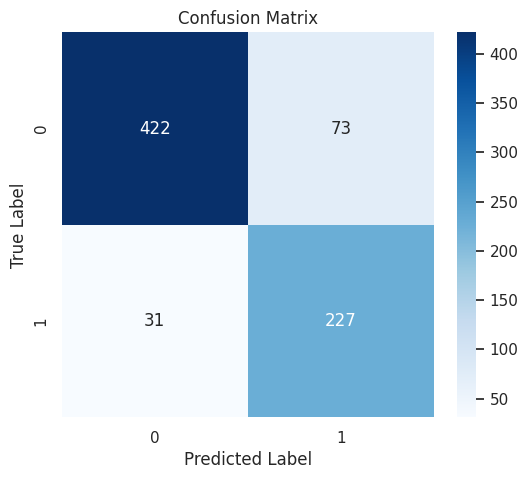

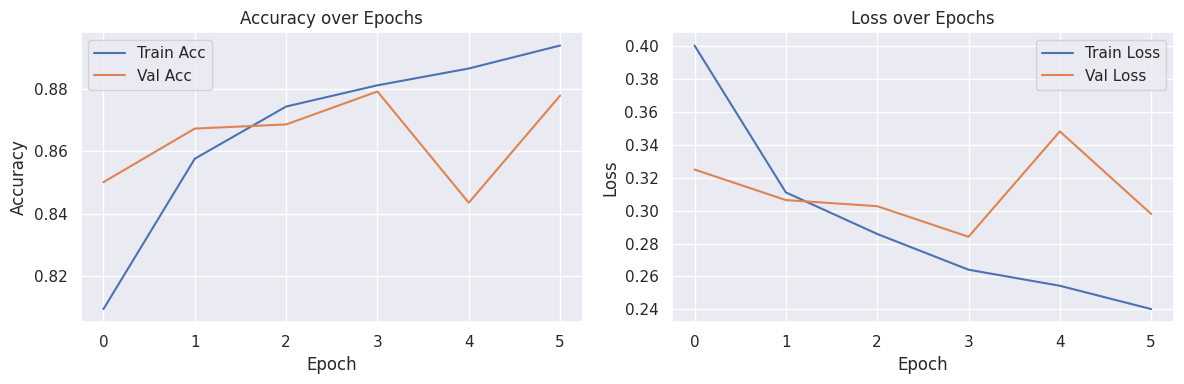

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Reshape, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
# Load dataset
df = pd.read_csv('/content/viproject/merged_Social_Media_LADDER/ladder_social_media.csv')

# Drop missing or empty rows
df = df.dropna(subset=['text', 'label'])
df['text'] = df['text'].astype(str)

# Tokenizer + BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Encode texts
MAX_LENGTH = 128
inputs = tokenizer(
    df['text'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=MAX_LENGTH,
    return_tensors='tf'
)

# Extract CLS token embeddings


# Convert to numpy now to keep track of size
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

batch_size = 32
cls_embeddings_list = []

for i in tqdm(range(0, len(input_ids), batch_size)):
    input_batch = {
        'input_ids': input_ids[i:i+batch_size],
        'attention_mask': attention_mask[i:i+batch_size]
    }
    outputs = bert_model(input_batch)
    cls_batch = outputs.last_hidden_state[:, 0, :]  # CLS token
    cls_embeddings_list.append(cls_batch.numpy())

# Combine into one array
X = np.concatenate(cls_embeddings_list, axis=0)

# Labels
y = df['label'].values
# Train-validation-test split (70/15/15)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in np.unique(y)}
print("Class Weights:", class_weight_dict)
model = Sequential([
    Reshape((1, 768), input_shape=(768,)),  # shape for LSTM
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)
# Predict
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### processing za LSTM

In [ ]:
!pip install nlpaug

#### bert based aug --- smarter (u final exp this preprocessing used), - ovo je meni bilo dobro, mozda vama ne bude, probajte i sa Hastinim i ovim

In [ ]:
# Updated full preprocessing pipeline using BERT-based augmentation

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nlpaug.augmenter.word as naw
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import nltk
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()):
    nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# --- 1. Load Dataset ---
df = pd.read_csv('/content/viproject/merged_Social_Media_LADDER/ladder_social_media.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# --- 2. Augment Class 1 (Threats) Using Contextual BERT ---
aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',
    action="substitute",
    device='cuda' if torch.cuda.is_available() else 'cpu',
    aug_p=0.2,
    top_k=5,
    stopwords=stop_words
)

augmented_texts = []
for idx, text in enumerate(texts):
    if labels[idx] == 1:
        try:
            augmented = aug.augment(text)
            augmented_texts.append(augmented)
        except:
            continue  # skip if fails

texts += augmented_texts
labels = np.concatenate([labels, np.ones(len(augmented_texts))])

# --- 3. Show Examples of Original vs. Augmented Threat Texts ---
print("Original vs. Augmented Examples (label == 1):\n")
count = 0
for idx, text in enumerate(texts[:len(df)]):  # only original range
    if labels[idx] == 1:
        try:
            augmented = aug.augment(text)
            print(f"Original : {text}")
            print(f"Augmented: {augmented}")
            print("-" * 60)
            count += 1
            if count >= 5:
                break
        except:
            continue



The following layers were not sharded: cls.predictions.transform.dense.weight, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.key.weight, bert.embeddings.position_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.dense.bias, cls.predictions.decoder.weight, cls.predictions.transform.dense.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.self.value.weight, bert.encoder.layer.*.attention.output.LayerNorm.bias, cls.predictions.bias, bert.encoder.layer.*.intermediate.dense.bias, bert.encoder.layer.*.attention.self.value.bias, cls.predictions.decoder.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.attention.output.dense.weight, cls.predictions.transform.LayerNorm.bias, bert.encoder.layer.*.intermediate.dense.weight, bert.embeddings.word_embeddings.weight, bert.encoder.la

Original vs. Augmented Examples (label == 1):

Original : using the device accelerometer sensor it implements a simple pedometer that is used to measure movements of the victim.
Augmented: ['using the device accelerometer sensor it implements a sensor system that is designed to measure brightness of the object.']
------------------------------------------------------------
Original : when the malware is first started on the device it will begin by hiding its icon from the application drawer.
Augmented: ['when the engine is not started on the device it will begin by hiding its location from the device menu.']
------------------------------------------------------------
Original : then it will ask for the accessibility service privilege as visible in the following screenshot:
Augmented: ['then it will check for the accessibility of information as shown in the following screenshot :']
------------------------------------------------------------
Original : after the user grants the request

In [ ]:
# --- 4. Save the Augmented Dataset ---

augmented_df = pd.DataFrame({
    'text': texts,
    'label': labels.astype(int)
})

# Save to CSV --- path
augmented_df.to_csv('/content/viproject/merged_Social_Media_LADDER/ladder_social_media_augmented.csv', index=False)

print("Augmented dataset saved successfully.")


Augmented dataset saved successfully.


In [ ]:
# --- 3. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 4. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels

#### bert based isto kao iznad ali bez augmented dijela

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay

import nltk
import contextlib
import io

with contextlib.redirect_stdout(io.StringIO()):
    nltk.download('stopwords', quiet=True)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# --- 1. Load Dataset ---
df = pd.read_csv('/content/viproject/merged_Social_Media_LADDER/ladder_social_media.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# --- 2. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 3. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels


### MODELI

#### No1 bidirectional lstm 84 81 better gener.    

In [ ]:

# --- 3. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 4. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels

# --- 5. Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# --- 6. Train/Val/Test Split ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# --- 7. Model Architecture ---
model = Sequential([
    Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(16, dropout=0.4, recurrent_dropout=0.2)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# --- 8. Early Stopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# --- 9. Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# --- 10. Evaluation ---
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 11. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 12. Training Curves ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Class weights: {0: np.float64(0.7610673135233474), 1: np.float64(1.4576074332171893)}
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 120s 929ms/step - accuracy: 0.6055 - loss: 0.7169 - val_accuracy: 0.6552 - val_loss: 0.7070
Epoch 2/20
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 80s 722ms/step - accuracy: 0.6332 - loss: 0.7064 - val_accuracy: 0.7109 - val_loss: 0.7080
Epoch 3/20
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 75s 662ms/step - accuracy: 0.5940 - loss: 0.7097 - val_accuracy: 0.7387 - val_loss: 0.6976
Epoch 4/20
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 79s 635ms/step - accuracy: 0.6418 - loss: 0.7093 - val_accuracy: 0.7692 - val_loss: 0.6822
Epoch 5/20
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 85s 663ms/step - accuracy: 0.6941 - loss: 0.6878 - val_accuracy: 0.7971 - val_loss: 0.6489
Epoch 6/20
110/110 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 71s 644ms/step - accuracy: 0.7449 - loss: 0.6576 - val_accuracy: 0.8276 - v

In [ ]:
model.save("iter2-no1-84-82.keras")

#### No2 exp 87 84 BEST


In [ ]:

# --- 3. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 4. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150 # INCREASED TO 150

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels

# --- 5. Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# --- 6. Train/Val/Test Split ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# --- 7. Model Architecture ---
model = Sequential([
    Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(48, dropout=0.4, recurrent_dropout=0.2)),  # LSTM SET TO 48 NEURONS
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
# ADDED LEARNING SCHEDULE
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=5 * len(X_train) // 32,  # decay every 5 epochs
    decay_rate=0.9,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [ ]:
model.save("iter2-no2-87-84.keras")

#### No3 boost threat class weights 89 84

In [ ]:

# --- 3. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 4. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 150

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels

# --- 5. Class Weights ---
# boost threat class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1] * 1.2}  #ADDED WEIGHTS TO THREAT CLASS SO ITS 'MORE' IMPORTANT

print(f"Class weights: {class_weight_dict}")

# --- 6. Train/Val/Test Split ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# --- 7. Model Architecture ---
model = Sequential([
    Embedding(MAX_NUM_WORDS, 128, input_length=MAX_SEQUENCE_LENGTH, trainable=True),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(48, dropout=0.4, recurrent_dropout=0.2)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=5 * len(X_train) // 32,  # decay every 5 epochs
    decay_rate=0.9,
    staircase=True
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


In [ ]:
model.save("iter2-no3.keras")

#### No4 stacked LSTM

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# --- 3. Shuffle Dataset ---
combined = list(zip(texts, labels))
np.random.shuffle(combined)
texts, labels = zip(*combined)
texts = list(texts)
labels = np.array(labels)

# --- 4. Tokenize and Pad ---
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
y = labels

# --- 5. Class Weights ---
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Class weights: {class_weight_dict}")

# --- 6. Train/Val/Test Split ---
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

# --- 7. Stacked LSTM Model Architecture ---
model = Sequential([
    Embedding(input_dim=MAX_NUM_WORDS, output_dim=128, input_length=MAX_SEQUENCE_LENGTH, trainable=True),
    SpatialDropout1D(0.3),

    # Stacked LSTM layers
    LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
    LSTM(32, dropout=0.3, recurrent_dropout=0.2),

    # Dense classification layers
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# --- Learning Rate Scheduler ---
lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=5 * len(X_train) // 32,  # decay every 5 epochs
    decay_rate=0.9,
    staircase=True
)

# --- Compile ---
optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

# --- Summary ---
model.summary()


In [ ]:
model.save("no4-91-90.keras")

### isto za sve modele - early stop, treniranje, eval.,test, plotanje rezultata

In [ ]:
# --- 8. Early Stopping ---
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
    verbose=1
)

# --- 9. Training ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)

# --- 10. Evaluation ---
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# --- 11. Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# --- 12. Training Curves ---
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save("no4-89-83.keras")

###  importovanje vec istreniranih lstm modela dobijenih pokretanjem kodova iznad

In [ ]:
# --- 1. Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- 2. Required Imports ---
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

# --- 3. Path to Model Directory ---
# models that used augmented dataset
base_path = '/content/drive/MyDrive/AI-Powered_Threat_Intelligence_for_Cybersecurity/LSTM_modeli/modeli-iteracija1'
# models that did not use augmented dataset --- performed slighlty worse
# base_path = '/content/drive/MyDrive/AI-Powered Threat Intelligence for Cybersecurity/LSTM modeli/LSTM/modeli-iteracija2'

# --- 4. List Models ---
model_files = [f for f in os.listdir(base_path) if f.endswith('.keras')]
print("Available models:", model_files)
# naming convention: noN-X-Y.keras where N is assigned number to the model (ID) and X and Y are recall and F1 score for class 1 (threat) respectively

# --- 5. Choose a model by name ---
model_name = 'no3-91-90.keras'  # Change to match desired model name, names - Available models: ['no1-93-90.keras', 'no2-87-88.keras', 'no4-91-90.keras', 'no3-91-90.keras']
model_path = os.path.join(base_path, model_name)

# --- 6. Load the Model ---
model = load_model(model_path)

model.summary()
# # --- 8. Predict ---
# y_pred_probs = model.predict(X_test)
# y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# # --- 9. Classification Report ---
# print("\nüìã Classification Report:")
# print(classification_report(y_test, y_pred))

# # --- 10. Confusion Matrix ---
# cm = confusion_matrix(y_test, y_pred)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.title(f'Confusion Matrix for {model_name}')
# plt.show()




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Available models: ['no1-93-90.keras', 'no2-87-88.keras', 'no4-91-90.keras', 'no3-91-90.keras']


Model: "sequential_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_6 (Embedding)         ‚îÇ (None, 150, 128)       ‚îÇ     1,280,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ spatial_dropout1d_6             ‚îÇ (None, 150, 128)       ‚îÇ             0 ‚îÇ
‚îÇ (SpatialDropout1D)              ‚îÇ                        ‚îÇ               ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_5 (Bidirectional) ‚îÇ (None, 96)             ‚îÇ        67,968 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                ‚îÇ (None, 16)             ‚îÇ         1,552 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)             ‚îÇ (None, 16)             ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_13 (Dense)                ‚îÇ (None, 1)              ‚îÇ            17 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 4,048,612 (15.44 MB)

 Trainable params: 1,349,537 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,699,075 (10.30 MB)

## Random Forest / Decision Tree

In [ ]:
!pip install imblearn;

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 238.4/238.4 kB 6.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                           accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve)
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/viproject/merged_Social_Media_LADDER/ladder_social_media.csv')

X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training label distribution: {pd.Series(y_train).value_counts()}")
print(f"Test label distribution: {pd.Series(y_test).value_counts()}")

Training set size: 4016
Test set size: 1004
Training label distribution: label
0    2638
1    1378
Name: count, dtype: int64
Test label distribution: label
0    660
1    344
Name: count, dtype: int64


In [ ]:
vectorizer = TfidfVectorizer(max_features=3000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_tfidf, y_train)

In [ ]:
rf_baseline = RandomForestClassifier(random_state=42, class_weight='balanced')
rf_baseline.fit(X_train_smote, y_train_smote)

y_pred_baseline = rf_baseline.predict(X_test_tfidf)
y_pred_proba_baseline = rf_baseline.predict_proba(X_test_tfidf)[:, 1]

baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("Baseline Model Performance:")
print(f"F1 Score: {baseline_f1:.4f}")
print(f"Accuracy: {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
print(f"AUC-ROC: {baseline_auc:.4f}\n")

print(classification_report(y_test, y_pred_baseline))

Baseline Model Performance:
F1 Score: 0.7888
Accuracy: 0.8426
Precision: 0.7302
Recall: 0.8576
AUC-ROC: 0.9286

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       660
           1       0.73      0.86      0.79       344

    accuracy                           0.84      1004
   macro avg       0.82      0.85      0.83      1004
weighted avg       0.85      0.84      0.85      1004



In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(50, 500),
    'max_depth': [5, 10, 15, 20, 25, 30, None],
    'min_samples_split': randint(2, 30),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.8, None],
    'bootstrap': [True, False]
}

In [ ]:
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

random_search = RandomizedSearchCV(
    rf,
    param_distributions,
    n_iter=60,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 10, 15, 20, 25, 30,
                                                      None],
                                        'max_features': ['sqrt', 'log2', 0.3,
                                                         0.5, 0.8, None],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b50e472e2d0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5015e83e50>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b5015e83dd0>},
                   random_state=42, scoring='f1', verbose=1)

In [ ]:
print(f"Random Search Best parameters:")
print(random_search.best_params_)
print(f"Random Search Best cross-validation F1 score: {random_search.best_score_:.4f}")

Random Search Best parameters:
{'bootstrap': False, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}
Random Search Best cross-validation F1 score: 0.8709


In [ ]:
random_results_df = pd.DataFrame(random_search.cv_results_)
top_random_results = random_results_df.nlargest(5, 'mean_test_score')[
    ['mean_test_score', 'std_test_score', 'params']
]
print("\nTop 5 Random Search Results:")
for i, (_, row) in enumerate(top_random_results.iterrows()):
    print(f"{i+1}. F1: {row['mean_test_score']:.4f} (¬±{row['std_test_score']:.4f}) - {row['params']}")


Top 5 Random Search Results:
1. F1: 0.8709 (¬±0.0108) - {'bootstrap': False, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 225}
2. F1: 0.8658 (¬±0.0109) - {'bootstrap': False, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 3, 'min_samples_split': 18, 'n_estimators': 441}
3. F1: 0.8624 (¬±0.0065) - {'bootstrap': True, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 290}
4. F1: 0.8576 (¬±0.0049) - {'bootstrap': True, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 357}
5. F1: 0.8554 (¬±0.0084) - {'bootstrap': False, 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 6, 'min_samples_split': 25, 'n_estimators': 282}


In [ ]:
best_random_params = random_search.best_params_

def create_param_range(best_val, param_type):
    if param_type == 'n_estimators':
        return [max(50, best_val - 50), best_val, best_val + 50]
    elif param_type == 'max_depth':
        if best_val is None:
            return [None]
        else:
            return [max(5, best_val - 5), best_val, best_val + 5]
    elif param_type == 'min_samples_split':
        return [max(2, best_val - 2), best_val, best_val + 2]
    elif param_type == 'min_samples_leaf':
        return [max(1, best_val - 1), best_val, best_val + 1]
    elif param_type == 'max_features':
        if isinstance(best_val, str):
            return [best_val, 'sqrt', 'log2']
        else:
            return [best_val, 'sqrt', 'log2']
    elif param_type == 'bootstrap':
        return [best_val]
    else:
        return [best_val]

In [ ]:
refined_param_grid = {}
for param, best_val in best_random_params.items():
    refined_param_grid[param] = create_param_range(best_val, param)

for param in refined_param_grid:
    refined_param_grid[param] = list(set(refined_param_grid[param]))
    if param == 'max_depth':
        refined_param_grid[param] = [x for x in refined_param_grid[param] if x is None or x > 0]

print(f"\nRefined parameter grid based on random search results:")
for param, values in refined_param_grid.items():
    print(f"{param}: {values}")

print(f"Total refined combinations: {np.prod([len(v) for v in refined_param_grid.values()])}")


Refined parameter grid based on random search results:
bootstrap: [False]
max_depth: [None]
max_features: [0.3, 'sqrt', 'log2']
min_samples_leaf: [1, 2]
min_samples_split: [2, 4]
n_estimators: [225, 275, 175]
Total refined combinations: 36


In [ ]:
grid_search = GridSearchCV(
    rf,
    refined_param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_smote, y_train_smote)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [False], 'max_depth': [None],
                         'max_features': [0.3, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [225, 275, 175]},
             scoring='f1', verbose=1)

In [ ]:
print(f"Grid Search Best parameters:")
print(grid_search.best_params_)
print(f"Grid Search Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Grid Search Best parameters:
{'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 175}
Grid Search Best cross-validation F1 score: 0.9091


In [ ]:
print(f"\nHyperparameter Tuning Comparison:")
print(f"Random Search Best F1: {random_search.best_score_:.4f}")
print(f"Grid Search Best F1: {grid_search.best_score_:.4f}")
print(f"Improvement from Grid Search: {((grid_search.best_score_ - random_search.best_score_) * 100):.3f}%")


Hyperparameter Tuning Comparison:
Random Search Best F1: 0.8709
Grid Search Best F1: 0.9091
Improvement from Grid Search: 3.824%


In [ ]:
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test_tfidf)
y_pred_proba_best = best_rf.predict_proba(X_test_tfidf)[:, 1]

best_f1 = f1_score(y_test, y_pred_best)
best_accuracy = accuracy_score(y_test, y_pred_best)
best_precision = precision_score(y_test, y_pred_best)
best_recall = recall_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_pred_proba_best)

print("\nBest Model Performance:")
print(f"F1 Score: {best_f1:.4f}")
print(f"Accuracy: {best_accuracy:.4f}")
print(f"Precision: {best_precision:.4f}")
print(f"Recall: {best_recall:.4f}")
print(f"AUC-ROC: {best_auc:.4f}\n")


Best Model Performance:
F1 Score: 0.8162
Accuracy: 0.8685
Precision: 0.7834
Recall: 0.8517
AUC-ROC: 0.9370



In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Baseline', 'Random Search', 'Grid Search'],
    'F1 Score': [baseline_f1, f1_score(y_test, random_search.best_estimator_.predict(X_test_tfidf)), best_f1],
    'Accuracy': [baseline_accuracy, accuracy_score(y_test, random_search.best_estimator_.predict(X_test_tfidf)), best_accuracy],
    'Precision': [baseline_precision, precision_score(y_test, random_search.best_estimator_.predict(X_test_tfidf)), best_precision],
    'Recall': [baseline_recall, recall_score(y_test, random_search.best_estimator_.predict(X_test_tfidf)), best_recall],
    'AUC-ROC': [baseline_auc, roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test_tfidf)[:, 1]), best_auc]
})

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
           Model  F1 Score  Accuracy  Precision    Recall   AUC-ROC
0       Baseline  0.788770  0.842629   0.730198  0.857558  0.928632
1  Random Search  0.767313  0.832669   0.732804  0.805233  0.887927
2    Grid Search  0.816156  0.868526   0.783422  0.851744  0.936989


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       660
           1       0.78      0.85      0.82       344

    accuracy                           0.87      1004
   macro avg       0.85      0.86      0.86      1004
weighted avg       0.87      0.87      0.87      1004



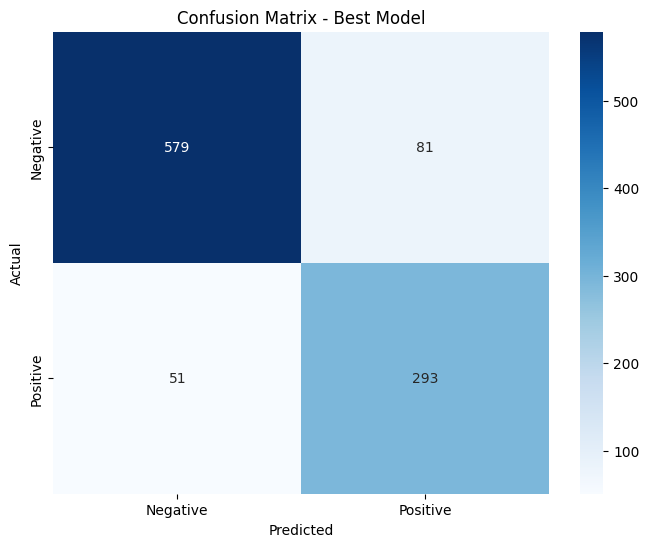

In [ ]:
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix - Best Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

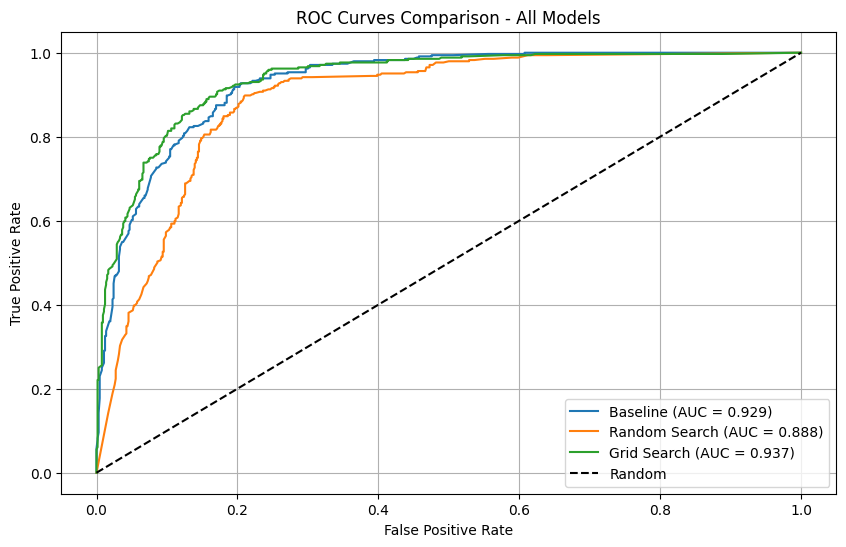

In [ ]:
# Calculate ROC curves for all models
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_proba_baseline)
fpr_random, tpr_random, _ = roc_curve(y_test, random_search.best_estimator_.predict_proba(X_test_tfidf)[:, 1])
fpr_best, tpr_best, _ = roc_curve(y_test, y_pred_proba_best)

plt.figure(figsize=(10, 6))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline (AUC = {baseline_auc:.3f})')
plt.plot(fpr_random, tpr_random, label=f'Random Search (AUC = {roc_auc_score(y_test, random_search.best_estimator_.predict_proba(X_test_tfidf)[:, 1]):.3f})')
plt.plot(fpr_best, tpr_best, label=f'Grid Search (AUC = {best_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison - All Models')
plt.legend()
plt.grid(True)
plt.show()

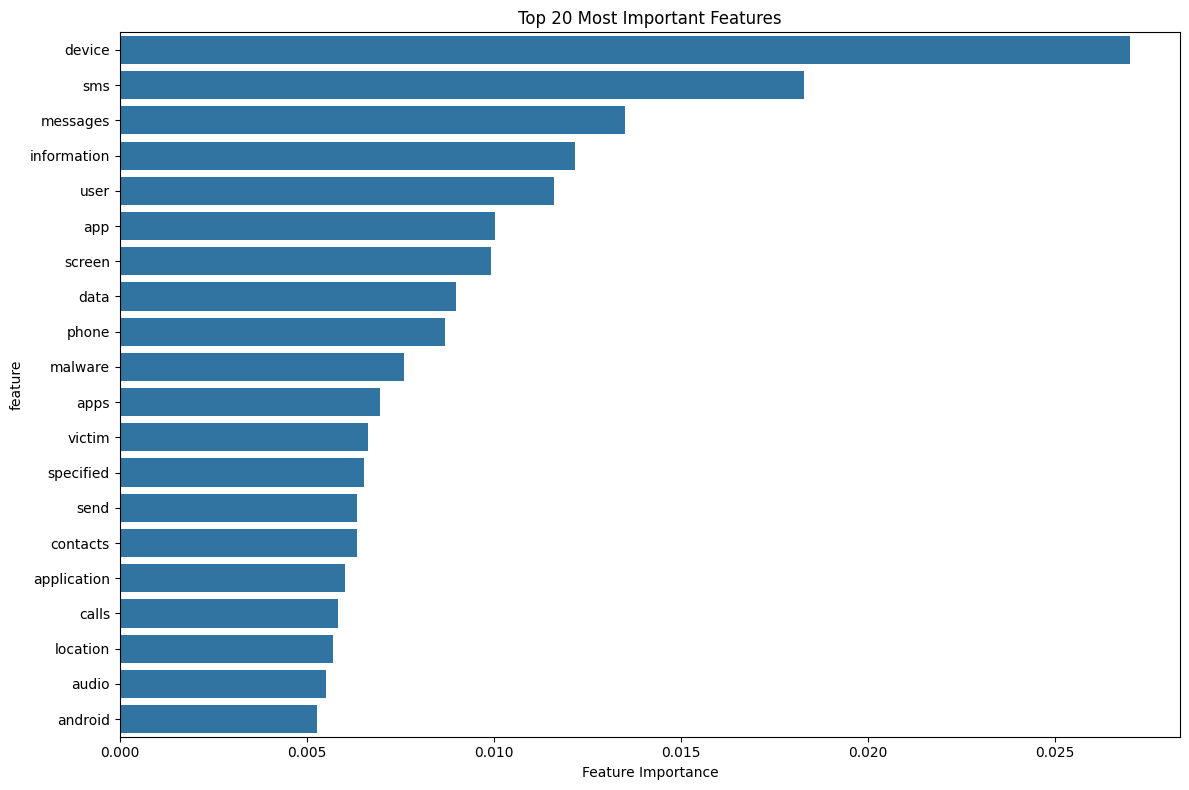

Top 10 Most Important Features:
          feature  importance
740        device    0.026988
2336          sms    0.018278
1664     messages    0.013493
1365  information    0.012173
2769         user    0.011615
231           app    0.010025
2241       screen    0.009923
685          data    0.008997
1915        phone    0.008689
1616      malware    0.007600


In [ ]:
# Get feature importance from best model
feature_importance = best_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Plot top 20 most important features
plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature')
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

print("Top 10 Most Important Features:")
print(importance_df.head(10))

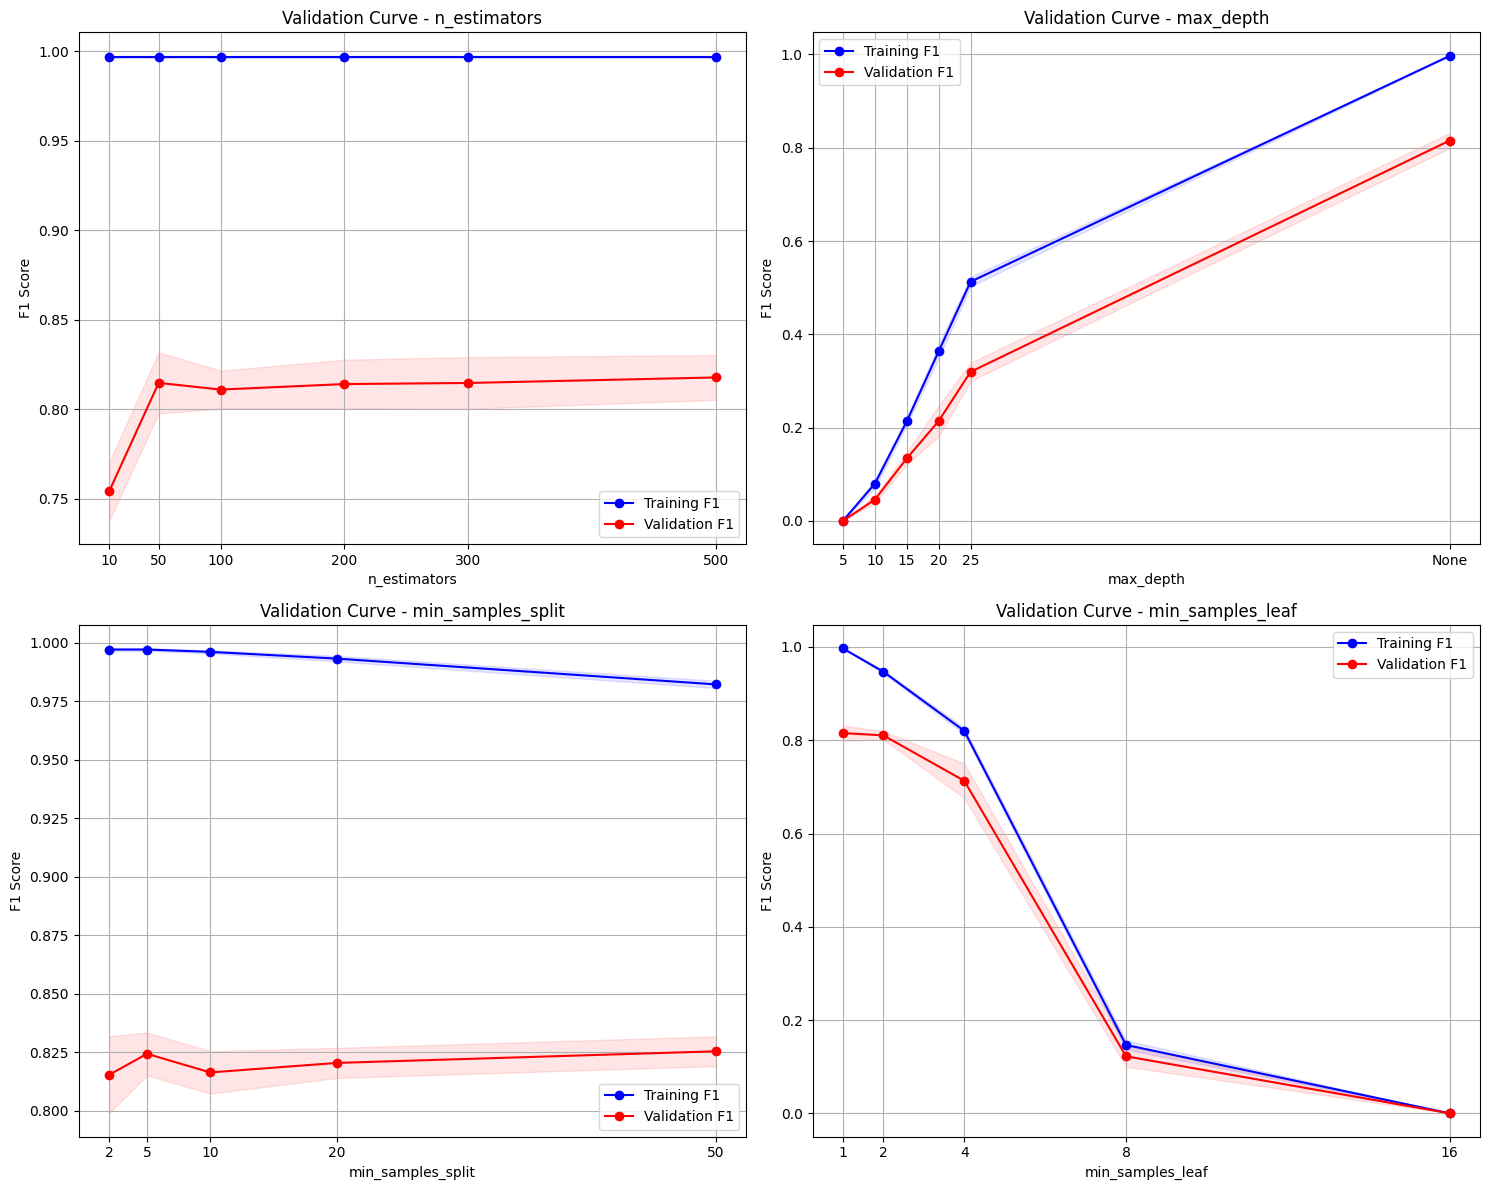

In [ ]:
params_to_analyze = {
    'n_estimators': [10, 50, 100, 200, 300, 500],
    'max_depth': [5, 10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 20, 50],
    'min_samples_leaf': [1, 2, 4, 8, 16]
}

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (param_name, param_range) in enumerate(params_to_analyze.items()):
    if i >= 4:
        break

    base_params = grid_search.best_params_.copy()

    train_scores, val_scores = validation_curve(
        RandomForestClassifier(random_state=42, **{k: v for k, v in base_params.items() if k != param_name}),
        X_train_tfidf, y_train,
        param_name=param_name,
        param_range=param_range,
        cv=5, scoring='f1', n_jobs=-1
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plot_param_range = [100 if x is None else x for x in param_range]

    axes[i].plot(plot_param_range, train_mean, 'o-', color='blue', label='Training F1')
    axes[i].fill_between(plot_param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[i].plot(plot_param_range, val_mean, 'o-', color='red', label='Validation F1')
    axes[i].fill_between(plot_param_range, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')

    axes[i].set_xticks(plot_param_range)
    axes[i].set_xticklabels([str(x) for x in param_range])

    axes[i].set_xlabel(param_name)
    axes[i].set_ylabel('F1 Score')
    axes[i].set_title(f'Validation Curve - {param_name}')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

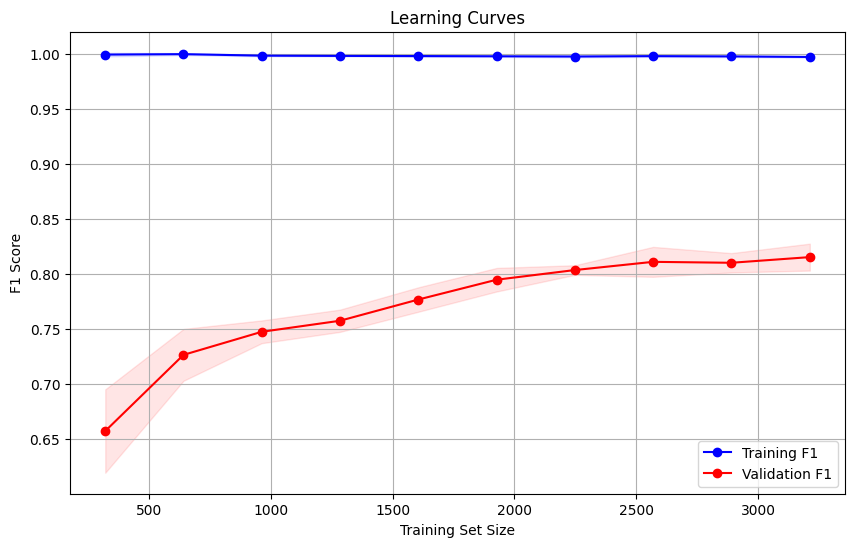

In [ ]:
train_sizes, train_scores_lc, val_scores_lc = learning_curve(
    best_rf, X_train_tfidf, y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5, scoring='f1', n_jobs=-1
)

train_mean_lc = np.mean(train_scores_lc, axis=1)
train_std_lc = np.std(train_scores_lc, axis=1)
val_mean_lc = np.mean(val_scores_lc, axis=1)
val_std_lc = np.std(val_scores_lc, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean_lc, 'o-', color='blue', label='Training F1')
plt.fill_between(train_sizes, train_mean_lc - train_std_lc, train_mean_lc + train_std_lc, alpha=0.1, color='blue')
plt.plot(train_sizes, val_mean_lc, 'o-', color='red', label='Validation F1')
plt.fill_between(train_sizes, val_mean_lc - val_std_lc, val_mean_lc + val_std_lc, alpha=0.1, color='red')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curves')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
y_pred_model1 = rf_baseline.predict(X_test_tfidf)
y_pred_model2 = best_rf.predict(X_test_tfidf)

acc1 = f1_score(y_test, y_pred_model1)
acc2 = f1_score(y_test, y_pred_model2)

print(f"Baseline rf model: {acc1:.4f}")
print(f"Best rf model: {acc2:.4f}")

accuracy_improvement = acc2 - acc1
percent_increase = 100 * accuracy_improvement / acc1

print(f"Absolute accuracy improvement: {accuracy_improvement:.4f}")
print(f"Relative percentage increase: {percent_increase:.2f}%")


Baseline rf model: 0.7888
Best rf model: 0.8162
Absolute accuracy improvement: 0.0274
Relative percentage increase: 3.47%
